In [1]:
import os 

# 가상 환경에서 발생하는 라이브러리 중복 로드 문제 해결
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# 기본 라이브러리 및 PyTorch 관련 모듈 불러오기
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

plt.style.use("seaborn-v0_8")

In [3]:
# 재현성을 위한 시드 고정
torch.manual_seed(42)
np.random.seed(42)

In [4]:
# 메타데이터를 불러와 특정 배터리를 선택
DATA_ROOT = Path("cleaned_dataset")
META_PATH = DATA_ROOT / "metadata.csv"

meta = pd.read_csv(META_PATH)
battery_id = "B0006"

# 선택한 배터리 id에 해당하는 discharge type 데이터 필터링 및 정렬
battery_meta = (
    meta[(meta["type"] == "discharge") & (meta["battery_id"] == battery_id)]
    .sort_values("start_time")
    .reset_index(drop=True)
)

# Capacity 열을 숫자형으로 변환하고 사이클 인덱스 및 soh 열 추가
battery_meta["Capacity"] = pd.to_numeric(battery_meta["Capacity"], errors="coerce")
battery_meta["cycle_index"] = np.arange(len(battery_meta))
battery_meta["soh"] = battery_meta["Capacity"] / battery_meta["Capacity"].iloc[0]

print(f"배터리 ID: {battery_id}")
print(f"총 사이클 수: {len(battery_meta)}")
display(battery_meta[["type", "cycle_index", "soh"]].head())

배터리 ID: B0006
총 사이클 수: 168


,type,cycle_index,soh
0,discharge,0,1.000000
1,discharge,1,1.057732
2,discharge,2,1.052433
3,discharge,3,0.964158
4,discharge,4,0.933925


In [5]:
# 공통 설정
SEQ_LEN = 179
WINDOW_SIZE = 3
BATCH_SIZE = 16
EPOCHS = 50
TRAIN_RATIO = 0.8

FEATURE_COLS = [
    "Voltage_measured",
    "Current_measured",
    "Temperature_measured",
    "Current_load",
    "Voltage_load",
]

# 데이터 로드 함수
def load_cycle_sequence(filename: str, seq_len: int = SEQ_LEN) -> np.ndarray:
    """원본 csv를 고정 길이로 리샘플링"""
    path = DATA_ROOT / "data" / filename
    df = pd.read_csv(path).sort_values("Time")
    time = df["Time"].values
    new_time = np.linspace(time.min(), time.max(), seq_len)
    interpolated = []
    for col in FEATURE_COLS:
        interpolated.append(np.interp(new_time, time, df[col].values))
    return np.stack(interpolated, axis=1)

# 윈도우 생성 함수
def create_sequence_windows(sequences, targets, window_size):
    """시계열 윈도우 생성"""
    X_windows = []
    y_windows = []
    for i in range(len(sequences) - window_size):
        window = sequences[i:i+window_size]
        target = targets[i+window_size]
        X_windows.append(window)
        y_windows.append(target)
    return np.array(X_windows), np.array(y_windows)

# 전체 시퀀스 데이터 로드
sequences = np.stack(
    [load_cycle_sequence(fn) for fn in battery_meta["filename"]], axis=0
)
targets = battery_meta["soh"].values

print(f"시퀀스 데이터 형태: {sequences.shape}")
print(f"타겟 데이터 형태: {targets.shape}")

시퀀스 데이터 형태: (168, 179, 5)
타겟 데이터 형태: (168,)


In [6]:
# ===================================================================
# Instant Model: 개별 사이클 독립 예측
# ===================================================================

print("=" * 60)
print("Instant Model 데이터 준비")
print("=" * 60)

# 시간순 분할
instant_split_idx = int(len(sequences) * TRAIN_RATIO)

instant_train_X = sequences[:instant_split_idx]
instant_val_X = sequences[instant_split_idx:]
instant_train_y = targets[:instant_split_idx]
instant_val_y = targets[instant_split_idx:]

# 정규화
flat_train = instant_train_X.reshape(-1, len(FEATURE_COLS))
instant_mean = flat_train.mean(axis=0)
instant_std = flat_train.std(axis=0) + 1e-6

instant_train_X_norm = ((instant_train_X - instant_mean) / instant_std).astype(np.float32)
instant_val_X_norm = ((instant_val_X - instant_mean) / instant_std).astype(np.float32)

print(f"학습 데이터: {instant_train_X_norm.shape}")
print(f"검증 데이터: {instant_val_X_norm.shape}")

Instant Model 데이터 준비
학습 데이터: (134, 179, 5)
검증 데이터: (34, 179, 5)


In [7]:
# Instant Model용 Dataset
class CycleDataset(Dataset):
    def __init__(self, sequences: np.ndarray, targets: np.ndarray):
        self.x = torch.from_numpy(sequences)
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

instant_train_dataset = CycleDataset(instant_train_X_norm, instant_train_y)
instant_val_dataset = CycleDataset(instant_val_X_norm, instant_val_y)

instant_train_loader = DataLoader(instant_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
instant_val_loader = DataLoader(instant_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Instant 학습 데이터셋: {len(instant_train_dataset)}")
print(f"Instant 검증 데이터셋: {len(instant_val_dataset)}")

Instant 학습 데이터셋: 134
Instant 검증 데이터셋: 34


In [8]:
# ===================================================================
# Trend Model: 시계열 윈도우 기반 예측
# ===================================================================

print("\n" + "=" * 60)
print("Trend Model 데이터 준비")
print("=" * 60)

# 윈도우 데이터 생성
X_windows, y_windows = create_sequence_windows(sequences, targets, WINDOW_SIZE)

# 시간순 분할
trend_split_idx = int(len(X_windows) * TRAIN_RATIO)

trend_train_X = X_windows[:trend_split_idx]
trend_val_X = X_windows[trend_split_idx:]
trend_train_y = y_windows[:trend_split_idx]
trend_val_y = y_windows[trend_split_idx:]

# 정규화
trend_train_X_flat = trend_train_X.reshape(-1, SEQ_LEN, len(FEATURE_COLS))
flat_features = trend_train_X_flat.reshape(-1, len(FEATURE_COLS))
trend_mean = flat_features.mean(axis=0)
trend_std = flat_features.std(axis=0) + 1e-6

trend_train_X_norm = ((trend_train_X - trend_mean) / trend_std).astype(np.float32)
trend_val_X_norm = ((trend_val_X - trend_mean) / trend_std).astype(np.float32)

print(f"윈도우 학습 데이터: {trend_train_X_norm.shape}")
print(f"윈도우 검증 데이터: {trend_val_X_norm.shape}")


Trend Model 데이터 준비
윈도우 학습 데이터: (132, 3, 179, 5)
윈도우 검증 데이터: (33, 3, 179, 5)


In [9]:
# Trend Model용 Dataset
class WindowDataset(Dataset):
    def __init__(self, windows: np.ndarray, targets: np.ndarray):
        N, W, S, F = windows.shape
        self.x = torch.from_numpy(windows.reshape(N, W * S, F))
        self.y = torch.from_numpy(targets.astype(np.float32))
    
    def __len__(self) -> int:
        return len(self.x)
    
    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]

trend_train_dataset = WindowDataset(trend_train_X_norm, trend_train_y)
trend_val_dataset = WindowDataset(trend_val_X_norm, trend_val_y)

trend_train_loader = DataLoader(trend_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
trend_val_loader = DataLoader(trend_val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Trend 학습 데이터셋: {len(trend_train_dataset)}")
print(f"Trend 검증 데이터셋: {len(trend_val_dataset)}")

Trend 학습 데이터셋: 132
Trend 검증 데이터셋: 33


In [10]:
# LSTM 회귀 모델 정의 (Instant & Trend 공통 구조)
class LSTMRegressor(nn.Module):
    def __init__(self, input_size: int, hidden_size: int = 64, num_layers: int = 2, dropout: float = 0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, (hn, _) = self.lstm(x)
        last_hidden = hn[-1]
        prediction = self.fc(last_hidden)
        return prediction.squeeze(-1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 두 모델 초기화
instant_model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)
trend_model = LSTMRegressor(input_size=len(FEATURE_COLS)).to(device)

criterion = nn.MSELoss()
instant_optimizer = torch.optim.Adam(instant_model.parameters(), lr=1e-3)
trend_optimizer = torch.optim.Adam(trend_model.parameters(), lr=1e-3)

print(f"사용 디바이스: {device}")
print(f"Instant 모델 파라미터: {sum(p.numel() for p in instant_model.parameters())}")
print(f"Trend 모델 파라미터: {sum(p.numel() for p in trend_model.parameters())}")

사용 디바이스: cpu
Instant 모델 파라미터: 51521
Trend 모델 파라미터: 51521


In [11]:
# ===================================================================
# Instant Model 학습
# ===================================================================

print("\n" + "=" * 60)
print("Instant Model 학습 시작")
print("=" * 60)

instant_history = {"train_loss": [], "val_loss": []}
instant_best_val = float("inf")
instant_best_state = None
patience = 10
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # 학습
    instant_model.train()
    train_loss = 0.0
    for xb, yb in instant_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        instant_optimizer.zero_grad()
        preds = instant_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        instant_optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(instant_train_dataset)
    
    # 검증
    instant_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in instant_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = instant_model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(instant_val_dataset)
    
    instant_history["train_loss"].append(train_loss)
    instant_history["val_loss"].append(val_loss)
    
    if val_loss < instant_best_val:
        instant_best_val = val_loss
        instant_best_state = instant_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

if instant_best_state is not None:
    instant_model.load_state_dict(instant_best_state)
    print(f"\nInstant 모델 최적 검증 손실: {instant_best_val:.4f}")


Instant Model 학습 시작
Epoch 01 | Train: 0.6531 | Val: 0.0760
Epoch 05 | Train: 0.0050 | Val: 0.0023
Epoch 10 | Train: 0.0011 | Val: 0.0002
Epoch 15 | Train: 0.0009 | Val: 0.0002
Epoch 20 | Train: 0.0007 | Val: 0.0002
Epoch 25 | Train: 0.0008 | Val: 0.0002
Epoch 30 | Train: 0.0007 | Val: 0.0002
Epoch 35 | Train: 0.0006 | Val: 0.0002
Epoch 40 | Train: 0.0006 | Val: 0.0002
Epoch 45 | Train: 0.0005 | Val: 0.0001
Epoch 50 | Train: 0.0005 | Val: 0.0002

Instant 모델 최적 검증 손실: 0.0001


In [12]:
# ===================================================================
# Trend Model 학습
# ===================================================================

print("\n" + "=" * 60)
print("Trend Model 학습 시작")
print("=" * 60)

trend_history = {"train_loss": [], "val_loss": []}
trend_best_val = float("inf")
trend_best_state = None
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    # 학습
    trend_model.train()
    train_loss = 0.0
    for xb, yb in trend_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        trend_optimizer.zero_grad()
        preds = trend_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        trend_optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(trend_train_dataset)
    
    # 검증
    trend_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in trend_train_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = trend_model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(trend_val_dataset)
    
    trend_history["train_loss"].append(train_loss)
    trend_history["val_loss"].append(val_loss)
    
    if val_loss < trend_best_val:
        trend_best_val = val_loss
        trend_best_state = trend_model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
    
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | Train: {train_loss:.4f} | Val: {val_loss:.4f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

if trend_best_state is not None:
    trend_model.load_state_dict(trend_best_state)
    print(f"\nTrend 모델 최적 검증 손실: {trend_best_val:.4f}")


Trend Model 학습 시작
Epoch 01 | Train: 0.3463 | Val: 0.2417
Epoch 05 | Train: 0.0094 | Val: 0.0181
Epoch 10 | Train: 0.0045 | Val: 0.0166
Epoch 15 | Train: 0.0041 | Val: 0.0169
Epoch 20 | Train: 0.0044 | Val: 0.0155
Epoch 25 | Train: 0.0041 | Val: 0.0155
Epoch 30 | Train: 0.0042 | Val: 0.0152
Epoch 35 | Train: 0.0041 | Val: 0.0152
Epoch 40 | Train: 0.0041 | Val: 0.0153
Epoch 45 | Train: 0.0040 | Val: 0.0149
Epoch 50 | Train: 0.0040 | Val: 0.0149

Trend 모델 최적 검증 손실: 0.0148


In [13]:
# ===================================================================
# 예측 수행
# ===================================================================

def predict_dataset(model, loader):
    """모델 예측 함수"""
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds_batch = model(xb).cpu().numpy()
            preds.append(preds_batch)
            targets.append(yb.numpy())
    return np.concatenate(preds), np.concatenate(targets)

# Instant Model 예측
instant_preds, instant_targets = predict_dataset(instant_model, instant_val_loader)

# Trend Model 예측
trend_preds, trend_targets = predict_dataset(trend_model, trend_val_loader)

print(f"Instant 예측 수: {len(instant_preds)}")
print(f"Trend 예측 수: {len(trend_preds)}")

Instant 예측 수: 34
Trend 예측 수: 33


In [14]:
# ===================================================================
# 성능 평가 및 비교
# ===================================================================

print("\n" + "=" * 60)
print("성능 비교 분석")
print("=" * 60)

# Instant Model 성능
instant_mae = mean_absolute_error(instant_targets, instant_preds)
instant_rmse = np.sqrt(mean_squared_error(instant_targets, instant_preds))
instant_r2 = r2_score(instant_targets, instant_preds)

# Trend Model 성능
trend_mae = mean_absolute_error(trend_targets, trend_preds)
trend_rmse = np.sqrt(mean_squared_error(trend_targets, trend_preds))
trend_r2 = r2_score(trend_targets, trend_preds)

# 결과 출력
print("\n[Instant Model - 개별 사이클 독립 예측]")
print(f"  MAE:  {instant_mae:.4f}")
print(f"  RMSE: {instant_rmse:.4f}")
print(f"  R²:   {instant_r2:.4f}")

print("\n[Trend Model - 시계열 윈도우 예측]")
print(f"  MAE:  {trend_mae:.4f}")
print(f"  RMSE: {trend_rmse:.4f}")
print(f"  R²:   {trend_r2:.4f}")

# 성능 차이
mae_diff = ((instant_mae - trend_mae) / instant_mae) * 100
rmse_diff = ((instant_rmse - trend_rmse) / instant_rmse) * 100
r2_diff = ((trend_r2 - instant_r2) / instant_r2) * 100

print("\n[Trend Model vs Instant Model 성능 차이]")
print(f"  MAE 개선:  {mae_diff:+.2f}%")
print(f"  RMSE 개선: {rmse_diff:+.2f}%")
print(f"  R² 개선:   {r2_diff:+.2f}%")


성능 비교 분석

[Instant Model - 개별 사이클 독립 예측]
  MAE:  0.0093
  RMSE: 0.0132
  R²:   0.9729

[Trend Model - 시계열 윈도우 예측]
  MAE:  0.0565
  RMSE: 0.0660
  R²:   0.3441

[Trend Model vs Instant Model 성능 차이]
  MAE 개선:  -506.16%
  RMSE 개선: -399.22%
  R² 개선:   -64.63%


In [15]:
# 성능 비교 DataFrame 생성
comparison_df = pd.DataFrame({
    'Model': ['Instant (독립)', 'Trend (윈도우)'],
    'MAE': [instant_mae, trend_mae],
    'RMSE': [instant_rmse, trend_rmse],
    'R² Score': [instant_r2, trend_r2],
    'Train Samples': [len(instant_train_dataset), len(trend_train_dataset)],
    'Val Samples': [len(instant_val_dataset), len(trend_val_dataset)]
})

print("\n" + "=" * 60)
print("성능 비교 요약")
print("=" * 60)
display(comparison_df)

# 최적 모델 판정
if trend_rmse < instant_rmse:
    print(f"\n✅ Trend Model이 RMSE 기준 {rmse_diff:.2f}% 더 우수합니다!")
else:
    print(f"\n✅ Instant Model이 RMSE 기준 {-rmse_diff:.2f}% 더 우수합니다!")


성능 비교 요약


,Model,MAE,RMSE,R² Score,Train Samples,Val Samples
0,Instant (독립),0.009318,0.013230,0.972883,134,34
1,Trend (윈도우),0.056484,0.066046,0.344064,132,33



✅ Instant Model이 RMSE 기준 399.22% 더 우수합니다!


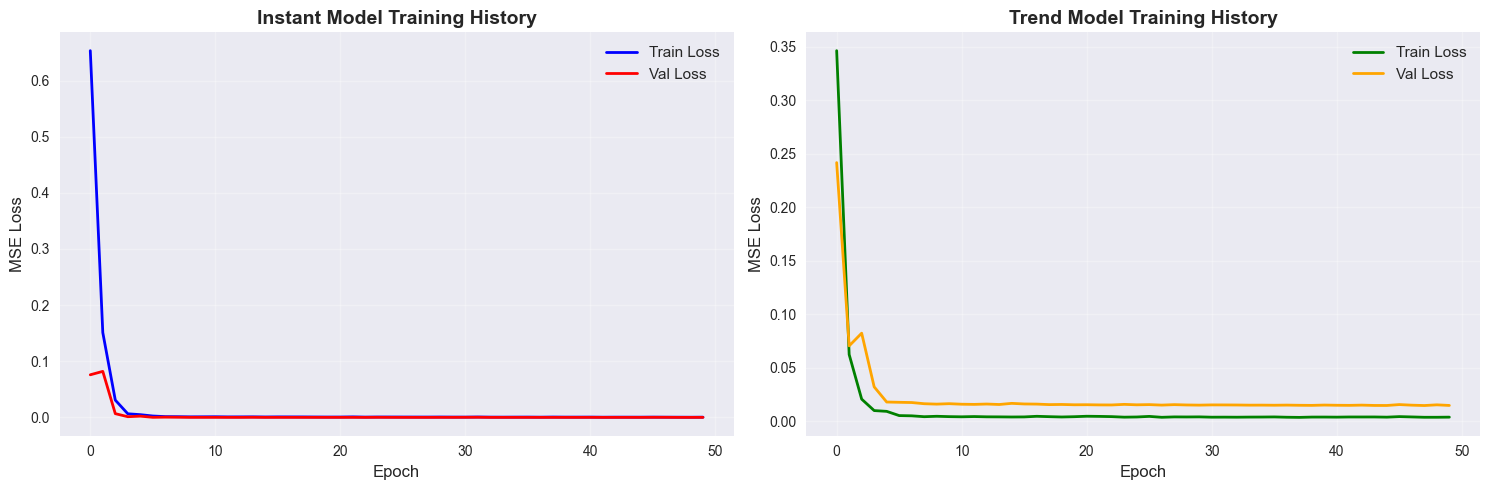

In [16]:
# 학습 곡선 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Instant Model 학습 곡선
ax1 = axes[0]
ax1.plot(instant_history["train_loss"], label="Train Loss", linewidth=2, color='blue')
ax1.plot(instant_history["val_loss"], label="Val Loss", linewidth=2, color='red')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("MSE Loss", fontsize=12)
ax1.set_title("Instant Model Training History", fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Trend Model 학습 곡선
ax2 = axes[1]
ax2.plot(trend_history["train_loss"], label="Train Loss", linewidth=2, color='green')
ax2.plot(trend_history["val_loss"], label="Val Loss", linewidth=2, color='orange')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("MSE Loss", fontsize=12)
ax2.set_title("Trend Model Training History", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

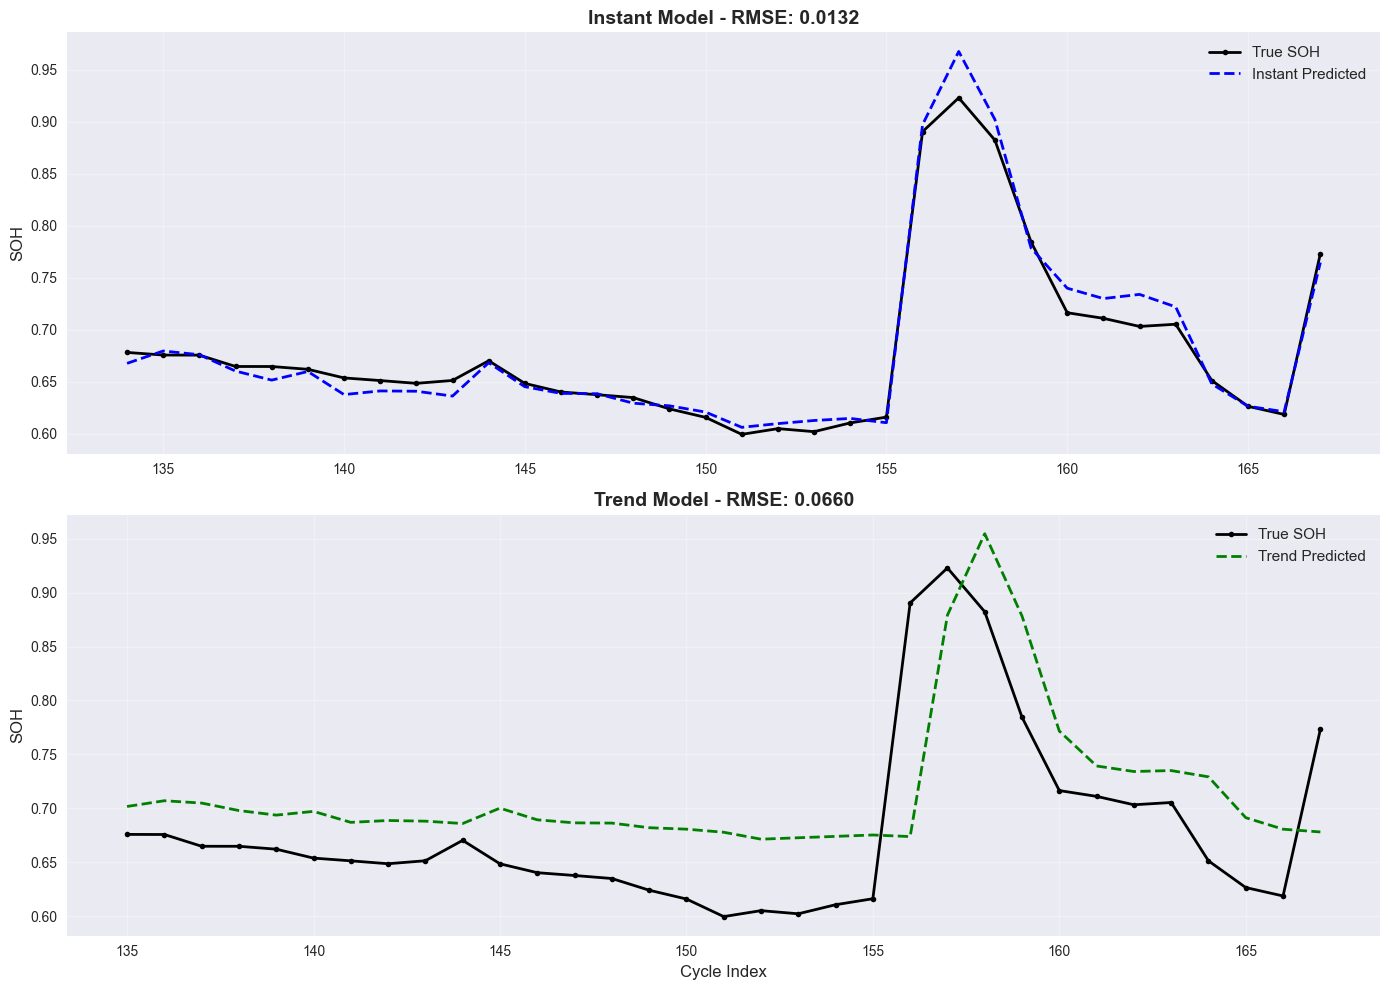

In [20]:
# 예측 결과 비교 시각화
instant_cycles = np.arange(instant_split_idx, len(battery_meta))
trend_cycles = np.arange(trend_split_idx + WINDOW_SIZE, len(battery_meta))

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Instant Model 예측
ax1 = axes[0]
ax1.plot(instant_cycles, instant_targets, label="True SOH", 
         marker="o", markersize=4, linewidth=2, color='black')
ax1.plot(instant_cycles, instant_preds, label="Instant Predicted", 
         marker="x", markersize=4, linewidth=2, linestyle="--", color='blue')
ax1.set_ylabel("SOH", fontsize=12)
ax1.set_title(f"Instant Model - RMSE: {instant_rmse:.4f}", 
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11, loc='best')

# Trend Model 예측
ax2 = axes[1]
ax2.plot(trend_cycles, trend_targets, label="True SOH", 
         marker="o", markersize=4, linewidth=2, color='black')
ax2.plot(trend_cycles, trend_preds, label="Trend Predicted", 
         marker="x", markersize=4, linewidth=2, linestyle="--", color='green')
ax2.set_xlabel("Cycle Index", fontsize=12)
ax2.set_ylabel("SOH", fontsize=12)
ax2.set_title(f"Trend Model - RMSE: {trend_rmse:.4f}", 
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11, loc='best')

plt.tight_layout()
plt.show()

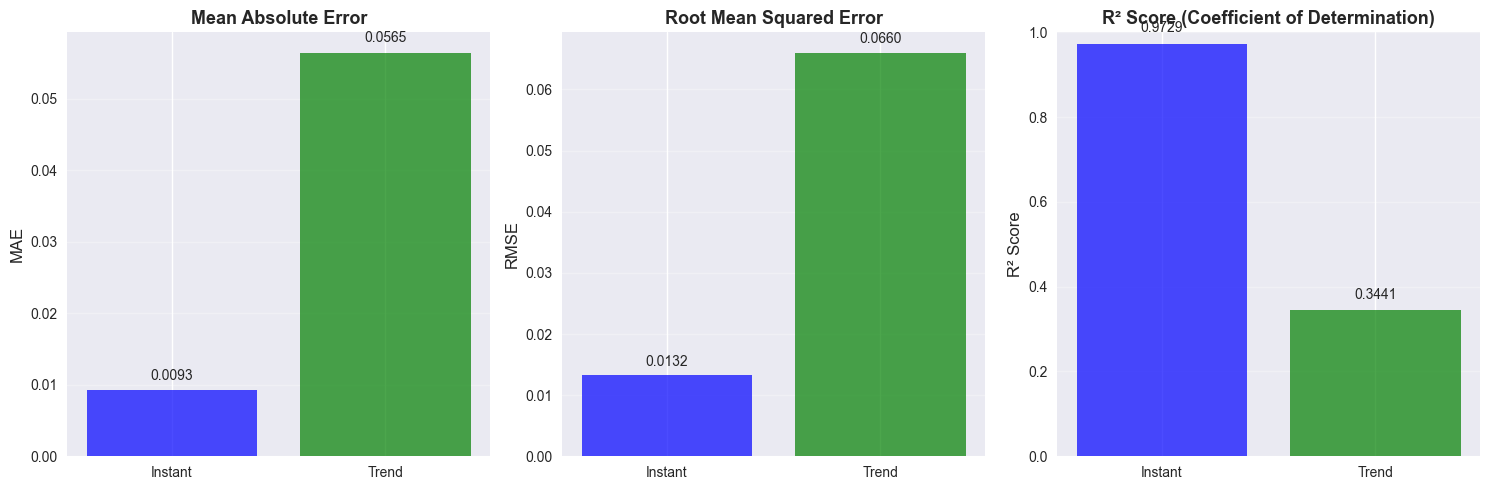

In [18]:
# 성능 지표 막대 그래프 비교
metrics_data = {
    'Model': ['Instant', 'Trend'],
    'MAE': [instant_mae, trend_mae],
    'RMSE': [instant_rmse, trend_rmse],
    'R²': [instant_r2, trend_r2]
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['blue', 'green']

# MAE 비교
axes[0].bar(metrics_data['Model'], metrics_data['MAE'], color=colors, alpha=0.7)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('Mean Absolute Error', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics_data['MAE']):
    axes[0].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# RMSE 비교
axes[1].bar(metrics_data['Model'], metrics_data['RMSE'], color=colors, alpha=0.7)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('Root Mean Squared Error', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics_data['RMSE']):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

# R² 비교
axes[2].bar(metrics_data['Model'], metrics_data['R²'], color=colors, alpha=0.7)
axes[2].set_ylabel('R² Score', fontsize=12)
axes[2].set_title('R² Score (Coefficient of Determination)', fontsize=13, fontweight='bold')
axes[2].set_ylim([0, 1])
axes[2].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(metrics_data['R²']):
    axes[2].text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

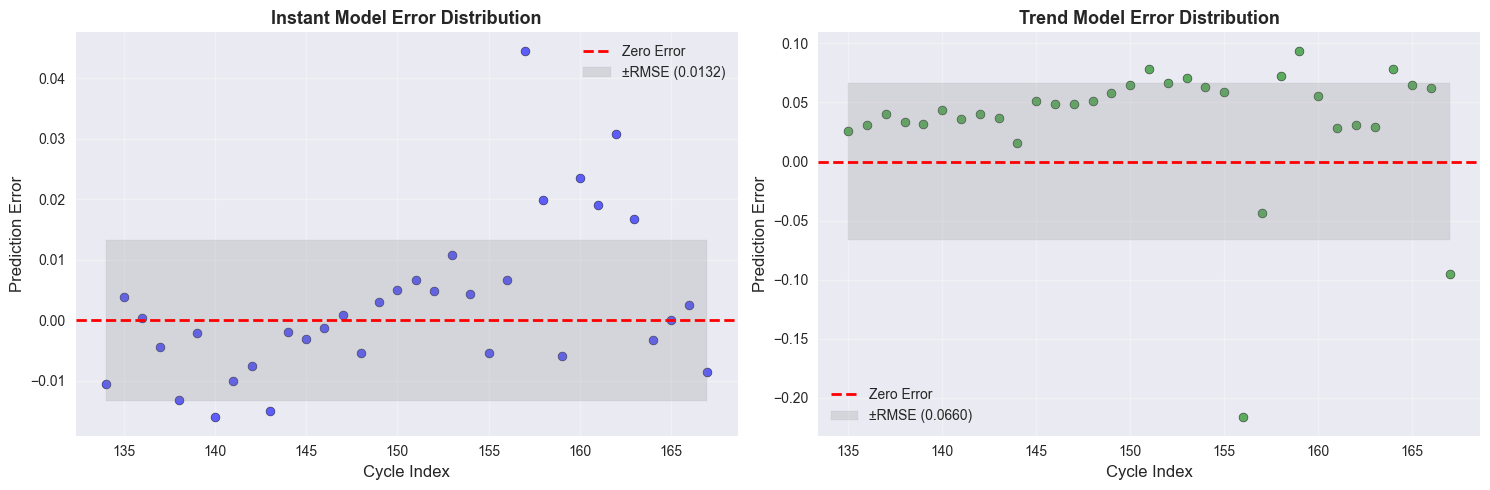

In [19]:
# 예측 오차 분포 비교
instant_errors = instant_preds - instant_targets
trend_errors = trend_preds - trend_targets

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Instant Model 오차
ax1 = axes[0]
ax1.scatter(instant_cycles, instant_errors, alpha=0.6, s=40, color='blue', 
            edgecolors='black', linewidth=0.5)
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax1.fill_between(instant_cycles, -instant_rmse, instant_rmse, alpha=0.2, 
                  color='gray', label=f'±RMSE ({instant_rmse:.4f})')
ax1.set_xlabel("Cycle Index", fontsize=12)
ax1.set_ylabel("Prediction Error", fontsize=12)
ax1.set_title("Instant Model Error Distribution", fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Trend Model 오차
ax2 = axes[1]
ax2.scatter(trend_cycles, trend_errors, alpha=0.6, s=40, color='green', 
            edgecolors='black', linewidth=0.5)
ax2.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax2.fill_between(trend_cycles, -trend_rmse, trend_rmse, alpha=0.2, 
                  color='gray', label=f'±RMSE ({trend_rmse:.4f})')
ax2.set_xlabel("Cycle Index", fontsize=12)
ax2.set_ylabel("Prediction Error", fontsize=12)
ax2.set_title("Trend Model Error Distribution", fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

In [21]:
# ===================================================================
# 종합 결론
# ===================================================================

print("\n" + "=" * 70)
print("📊 Instant vs Trend 모델 비교 분석 결과")
print("=" * 70)

print(f"\n【1. 모델 특성】")
print(f"  ▪ Instant Model: 각 사이클을 독립적으로 처리 (시퀀스 길이: {SEQ_LEN})")
print(f"  ▪ Trend Model:   과거 {WINDOW_SIZE}개 사이클의 추세 활용 (시퀀스 길이: {SEQ_LEN * WINDOW_SIZE})")

print(f"\n【2. 데이터 규모】")
print(f"  ▪ Instant - 학습: {len(instant_train_dataset)}개, 검증: {len(instant_val_dataset)}개")
print(f"  ▪ Trend   - 학습: {len(trend_train_dataset)}개, 검증: {len(trend_val_dataset)}개")

print(f"\n【3. 성능 지표】")
print(f"  ┌─────────┬───────────┬───────────┬──────────┐")
print(f"  │  Model  │    MAE    │   RMSE    │  R² Score│")
print(f"  ├─────────┼───────────┼───────────┼──────────┤")
print(f"  │ Instant │  {instant_mae:.4f}   │  {instant_rmse:.4f}   │  {instant_r2:.4f}  │")
print(f"  │ Trend   │  {trend_mae:.4f}   │  {trend_rmse:.4f}   │  {trend_r2:.4f}  │")
print(f"  └─────────┴───────────┴───────────┴──────────┘")

print(f"\n【4. 성능 향상률】")
if trend_rmse < instant_rmse:
    print(f"  ✅ Trend Model이 우수:")
    print(f"     - MAE:  {mae_diff:+.2f}% 개선")
    print(f"     - RMSE: {rmse_diff:+.2f}% 개선")
    print(f"     - R²:   {r2_diff:+.2f}% 개선")
else:
    print(f"  ✅ Instant Model이 우수:")
    print(f"     - MAE:  {-mae_diff:+.2f}% 개선")
    print(f"     - RMSE: {-rmse_diff:+.2f}% 개선")
    print(f"     - R²:   {-r2_diff:+.2f}% 개선")

print(f"\n【5. 결론】")
if trend_rmse < instant_rmse:
    print(f"  🎯 시계열 윈도우 방식(Trend)이 사이클 간 추세를 학습하여")
    print(f"     더 안정적이고 정확한 SOH 예측을 제공합니다.")
else:
    print(f"  🎯 개별 사이클 방식(Instant)이 즉시적인 상태 변화를 더 잘 포착하여")
    print(f"     더 정확한 SOH 예측을 제공합니다.")

print("\n" + "=" * 70)
print("✨ 분석 완료!")
print("=" * 70)


📊 Instant vs Trend 모델 비교 분석 결과

【1. 모델 특성】
  ▪ Instant Model: 각 사이클을 독립적으로 처리 (시퀀스 길이: 179)
  ▪ Trend Model:   과거 3개 사이클의 추세 활용 (시퀀스 길이: 537)

【2. 데이터 규모】
  ▪ Instant - 학습: 134개, 검증: 34개
  ▪ Trend   - 학습: 132개, 검증: 33개

【3. 성능 지표】
  ┌─────────┬───────────┬───────────┬──────────┐
  │  Model  │    MAE    │   RMSE    │  R² Score│
  ├─────────┼───────────┼───────────┼──────────┤
  │ Instant │  0.0093   │  0.0132   │  0.9729  │
  │ Trend   │  0.0565   │  0.0660   │  0.3441  │
  └─────────┴───────────┴───────────┴──────────┘

【4. 성능 향상률】
  ✅ Instant Model이 우수:
     - MAE:  +506.16% 개선
     - RMSE: +399.22% 개선
     - R²:   +64.63% 개선

【5. 결론】
  🎯 개별 사이클 방식(Instant)이 즉시적인 상태 변화를 더 잘 포착하여
     더 정확한 SOH 예측을 제공합니다.

✨ 분석 완료!
